# Dependencies and notebook settings

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.stats import diagnostic
import statsmodels.api as sm
from scipy.stats import norm, skewnorm, t, laplace, laplace_asymmetric, genextreme
from tqdm import tqdm
from IPython.core.display import display, HTML
from var_test import *

display(HTML("<style>.container { width:90% !important; }</style>"))
plt.style.use("ggplot")
mpl.rcParams["figure.dpi"] = 100

# Shallow data preparation / wrangling 

In [2]:
df = pd.read_csv(
    "../dataset/spx.csv",
    parse_dates=["Date"],
    names=["Date", "Open", "High", "Low", "Close", "Volume"],
    header=0,
    index_col="Date",
)
df = df[df.index < "2020-10-01"]
df["rr"] = (np.log(df.Close) - np.log(df.Close.shift(1))) * 100
df = df.tail(252 * 4)
df = df[["rr"]]
df.dropna(inplace=True)

# Models estimation and VaR calculation

In [3]:
hs_1 = list()
hs_25 = list()
norm_1 = list()
norm_25 = list()
skewnorm_1 = list()
skewnorm_25 = list()
t_1 = list()
t_25 = list()
laplace_1 = list()
laplace_25 = list()
laplace_asymmetric_1 = list()
laplace_asymmetric_25 = list()
genextreme_1 = list()
genextreme_25 = list()

for i in tqdm(range(0, 252)):
    y_train = df["rr"].iloc[i : i + 252 * 3].values
    maxima = df["rr"].iloc[i : i + 252 * 3].resample("W").min()
    var_alpha = [0.01, 0.025]

    tmp, tmp1 = np.quantile(y_train, var_alpha)
    hs_1.append(tmp)
    hs_25.append(tmp1)

    tmp, tmp1 = norm.ppf(var_alpha, *norm.fit(y_train))
    norm_1.append(tmp)
    norm_25.append(tmp1)

    tmp, tmp1 = skewnorm.ppf(var_alpha, *skewnorm.fit(y_train))
    skewnorm_1.append(tmp)
    skewnorm_25.append(tmp1)

    tmp, tmp1 = t.ppf(var_alpha, *t.fit(y_train))
    t_1.append(tmp)
    t_25.append(tmp1)

    tmp, tmp1 = laplace.ppf(var_alpha, *laplace.fit(y_train))
    laplace_1.append(tmp)
    laplace_25.append(tmp1)

    tmp, tmp1 = laplace_asymmetric.ppf(var_alpha, *laplace_asymmetric.fit(y_train))
    laplace_asymmetric_1.append(tmp)
    laplace_asymmetric_25.append(tmp1)

    tmp, tmp1 = genextreme.ppf(var_alpha, *genextreme.fit(maxima))
    genextreme_1.append(tmp)
    genextreme_25.append(tmp1)

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:40<00:00,  6.30it/s]


In [4]:
results_dict = {
    "rr":df.tail(252).rr.values,
    "hs_1": hs_1,
    "hs_25": hs_25,
    "norm_1": norm_1,
    "norm_25": norm_25,
    "skewnorm_1": skewnorm_1,
    "skewnorm_25": skewnorm_25,
    "t_1": t_1,
    "t_25": t_25,
    "laplace_1": laplace_1,
    "laplace_25": laplace_25,
    "laplaceasymmetric_1": laplace_asymmetric_1,
    "laplaceasymmetric_25": laplace_asymmetric_25,
    "genextreme_1": genextreme_1,
    "genextreme_25": genextreme_25,
}

In [5]:
results = pd.DataFrame(results_dict, index = df.tail(252).index)

In [6]:
results.head()

,rr,hs_1,hs_25,norm_1,norm_25,skewnorm_1,skewnorm_25,t_1,t_25,laplace_1,laplace_25,laplaceasymmetric_1,laplaceasymmetric_25,genextreme_1,genextreme_25
Date,,,,,,,,,,,,,,,
2019-10-02,-1.806544,-2.682787,-2.078959,-1.833538,-1.538453,-1.981445,-1.633284,-2.467717,-1.586700,-2.019657,-1.532792,-2.082516,-1.581789,-3.025894,-2.570695
2019-10-03,0.794038,-2.682787,-2.078959,-1.839374,-1.543551,-1.989246,-1.639694,-2.485518,-1.594033,-2.024159,-1.536239,-2.093941,-1.590299,-2.949771,-2.554852
2019-10-04,1.411674,-2.682787,-2.078959,-1.839374,-1.543552,-1.989248,-1.639696,-2.485592,-1.594063,-2.024162,-1.536241,-2.093980,-1.590325,-3.048949,-2.588461
2019-10-07,-0.448836,-2.682787,-2.078959,-1.840401,-1.544054,-1.990502,-1.640336,-2.490182,-1.596772,-2.028129,-1.539038,-2.093959,-1.590037,-3.048949,-2.588461
2019-10-08,-1.568317,-2.682787,-2.078959,-1.840243,-1.543912,-1.990349,-1.640197,-2.490530,-1.596741,-2.027881,-1.538848,-2.093776,-1.589893,-3.039341,-2.580248


In [7]:
results.tail()

,rr,hs_1,hs_25,norm_1,norm_25,skewnorm_1,skewnorm_25,t_1,t_25,laplace_1,laplace_25,laplaceasymmetric_1,laplaceasymmetric_25,genextreme_1,genextreme_25
Date,,,,,,,,,,,,,,,
2020-09-24,0.298295,-4.469605,-3.079883,-3.334557,-2.804011,-3.532205,-2.929614,-4.412882,-2.587065,-3.163560,-2.399667,-3.414198,-2.591552,-5.551501,-4.553844
2020-09-25,1.585048,-4.469605,-3.079883,-3.334321,-2.803763,-3.148135,-2.637672,-4.410568,-2.585932,-3.162501,-2.398406,-3.414501,-2.591672,-5.562902,-4.566087
2020-09-28,1.598215,-4.469605,-3.079883,-3.334409,-2.803461,-3.532709,-2.929480,-4.409321,-2.587304,-3.165316,-2.399816,-3.414881,-2.591671,-5.568338,-4.568896
2020-09-29,-0.482424,-4.469605,-3.079883,-3.334888,-2.803532,-3.533649,-2.929839,-4.403787,-2.588271,-3.169709,-2.402517,-3.417595,-2.593361,-5.525888,-4.710734
2020-09-30,0.821983,-4.469605,-3.079883,-3.336208,-2.804830,-3.534546,-2.930849,-4.398370,-2.589037,-3.174011,-2.406474,-3.421343,-2.596496,-5.551897,-4.554867


# Results backtesting

In [8]:
models = set([i.split("_")[0] for i in results_dict.keys()])
models.remove("rr")
alphas = ["1", "25"]

## Visualization -  realization of rates of return vs VaR forecasts

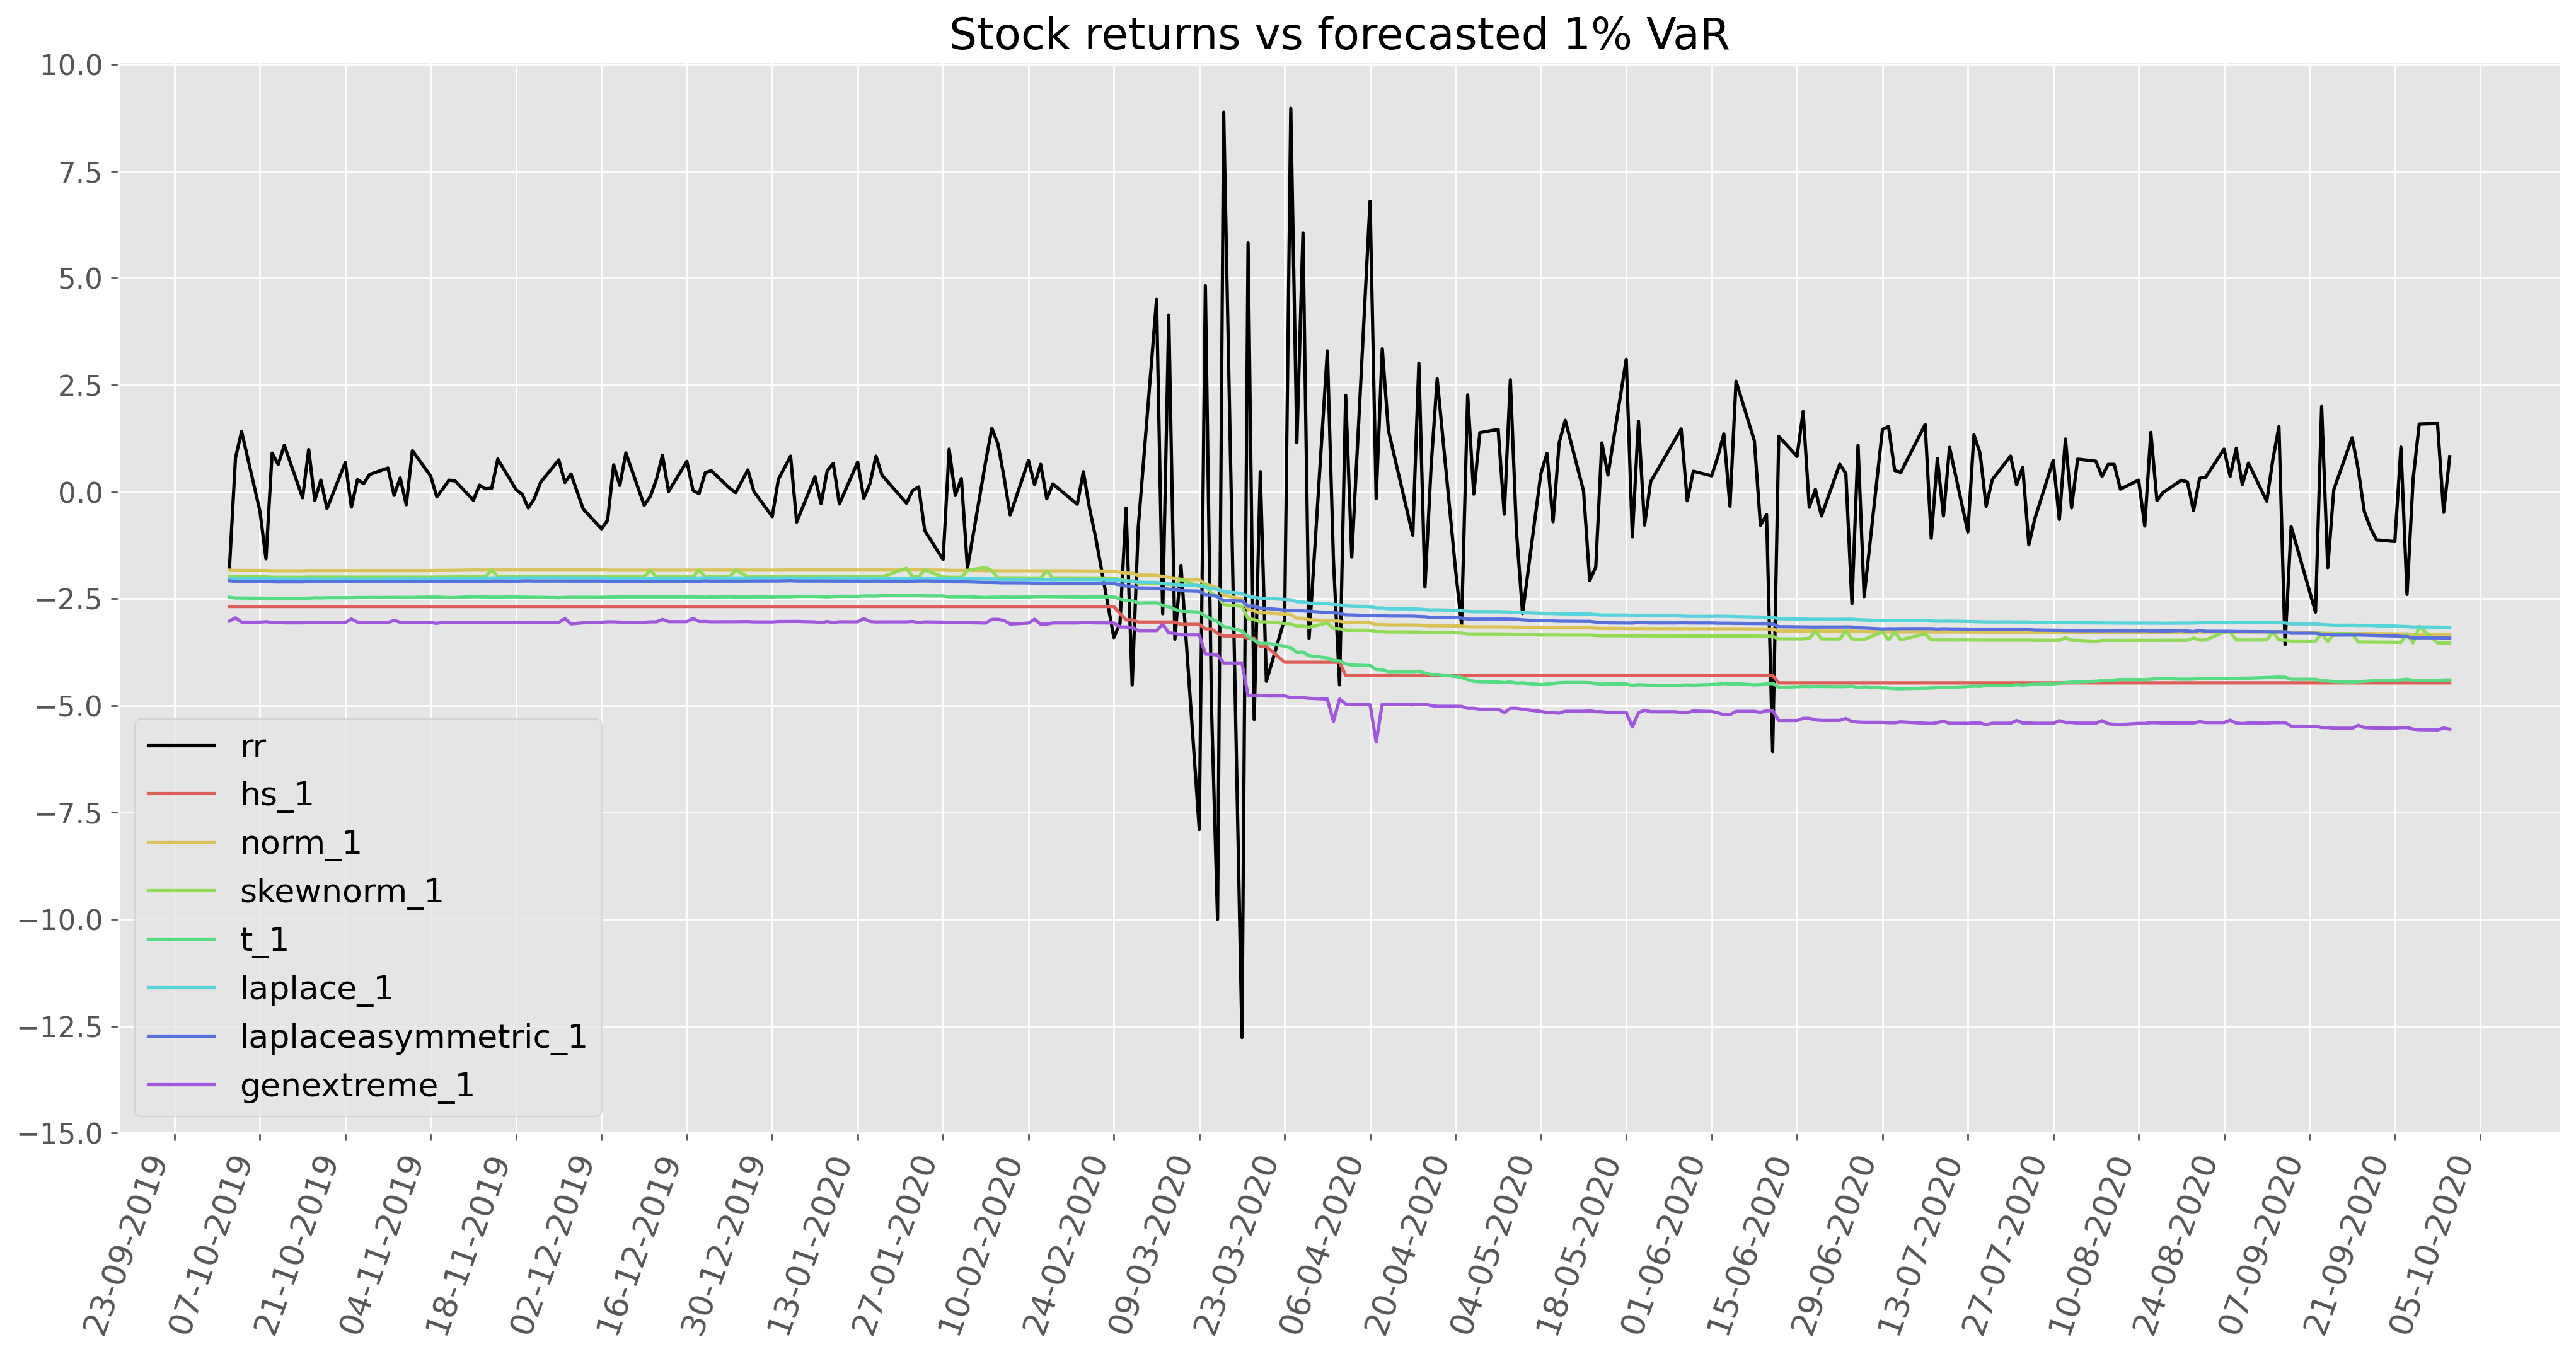

In [9]:
viz1_df = results.loc[:,(results.columns.str.endswith(("1","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz1_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted 1% VaR", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-15,12.5, 2.5),fontsize=13)
plt.show()

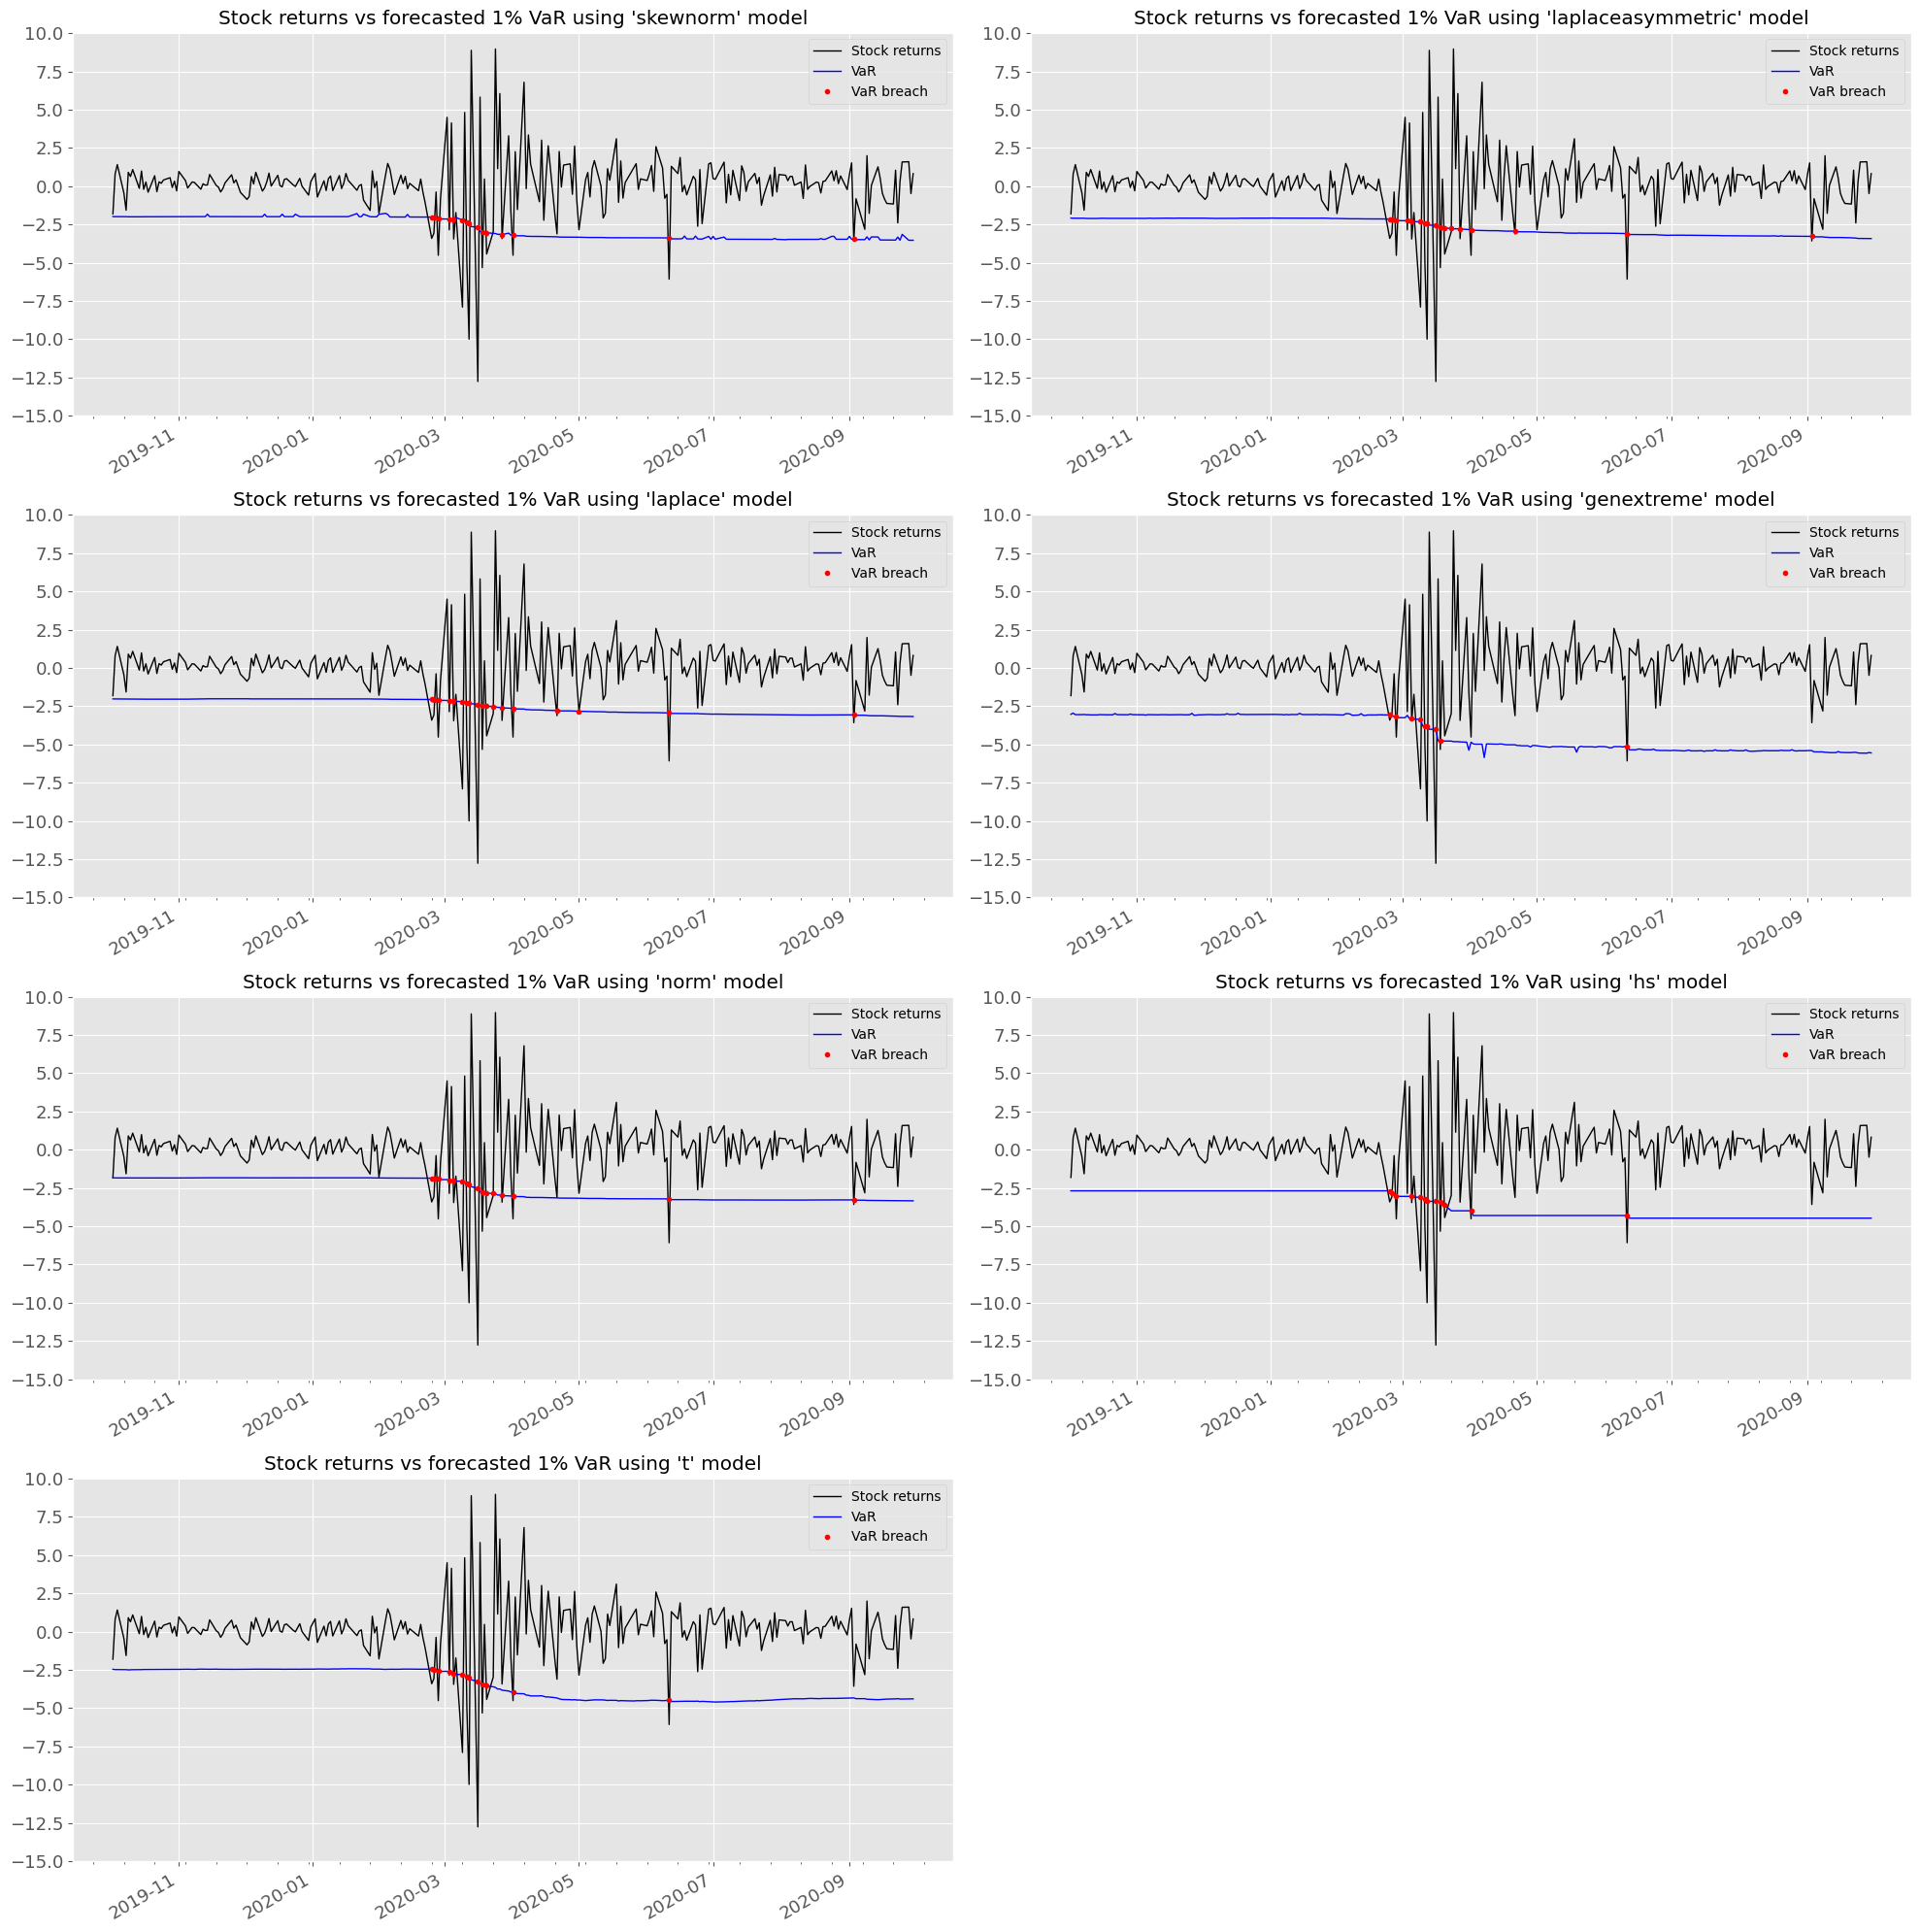

In [10]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))
for i, ax in zip(range(0,7), axes.flat):
    name = models_list[i] + "_1"
    viz1_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz1_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz1_df[name][viz1_df["rr"] < viz1_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 1% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-15,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
fig.delaxes(axes[3][1])
plt.show()

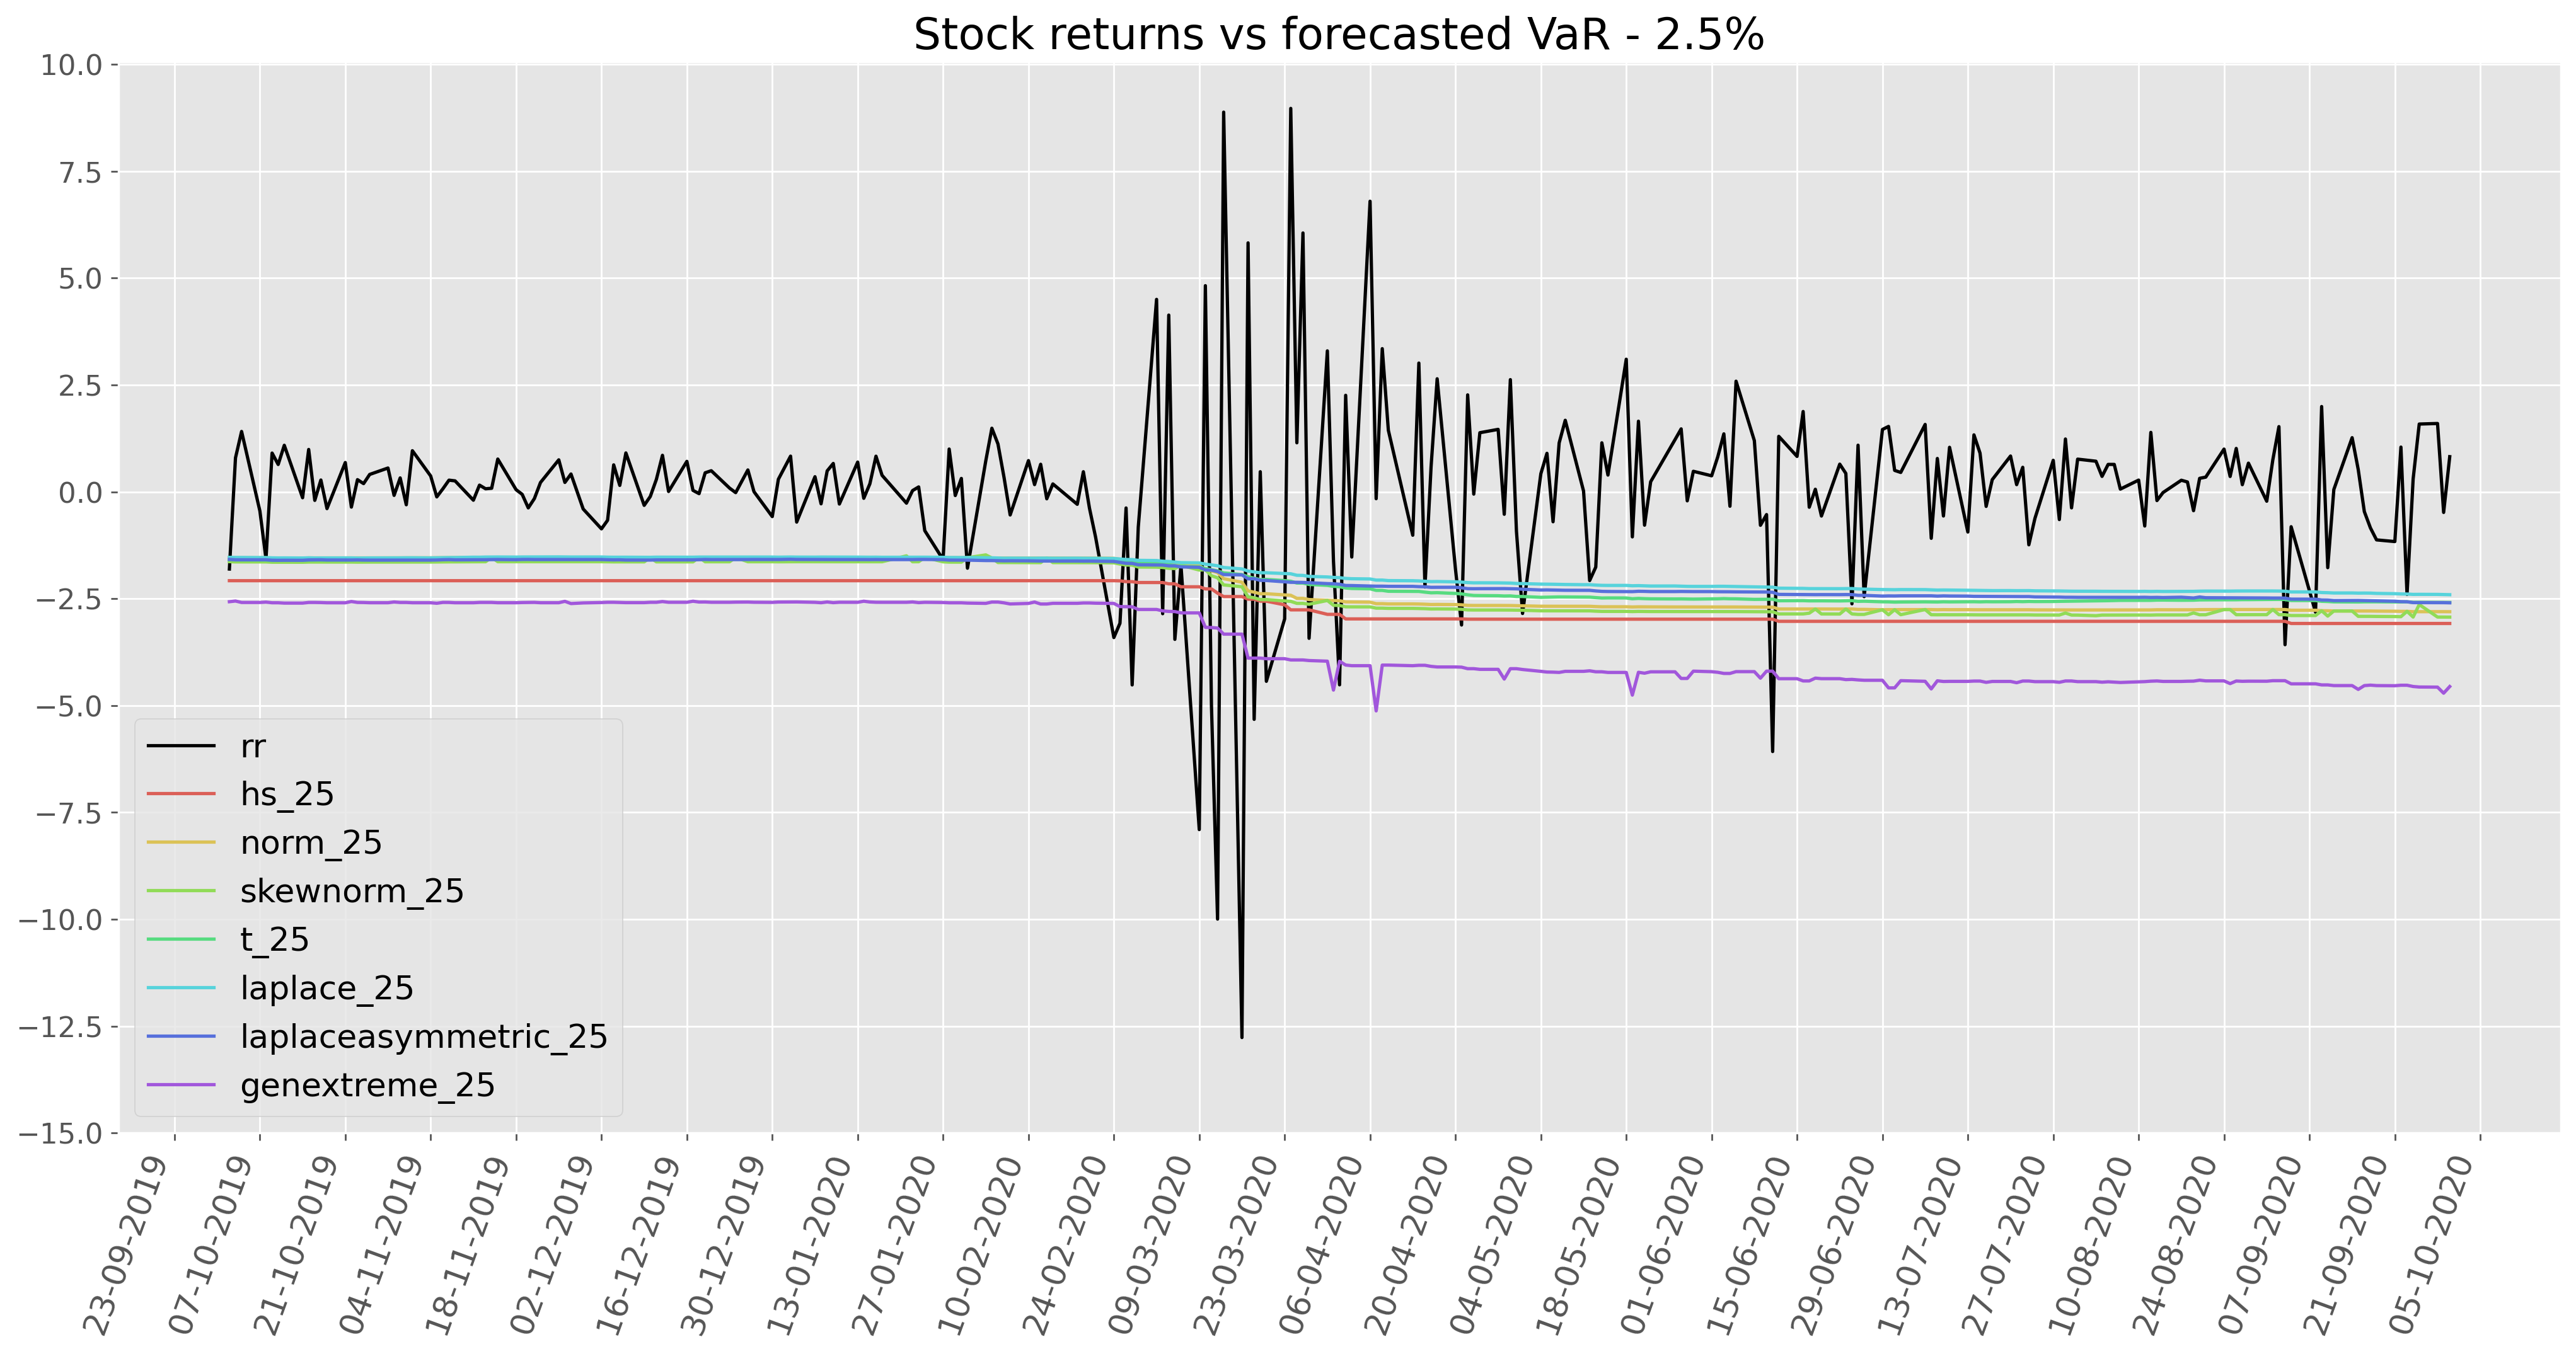

In [11]:
viz25_df = results.loc[:,(results.columns.str.endswith(("25","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz25_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted VaR - 2.5%", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-15,12.5, 2.5),fontsize=13)
plt.show()

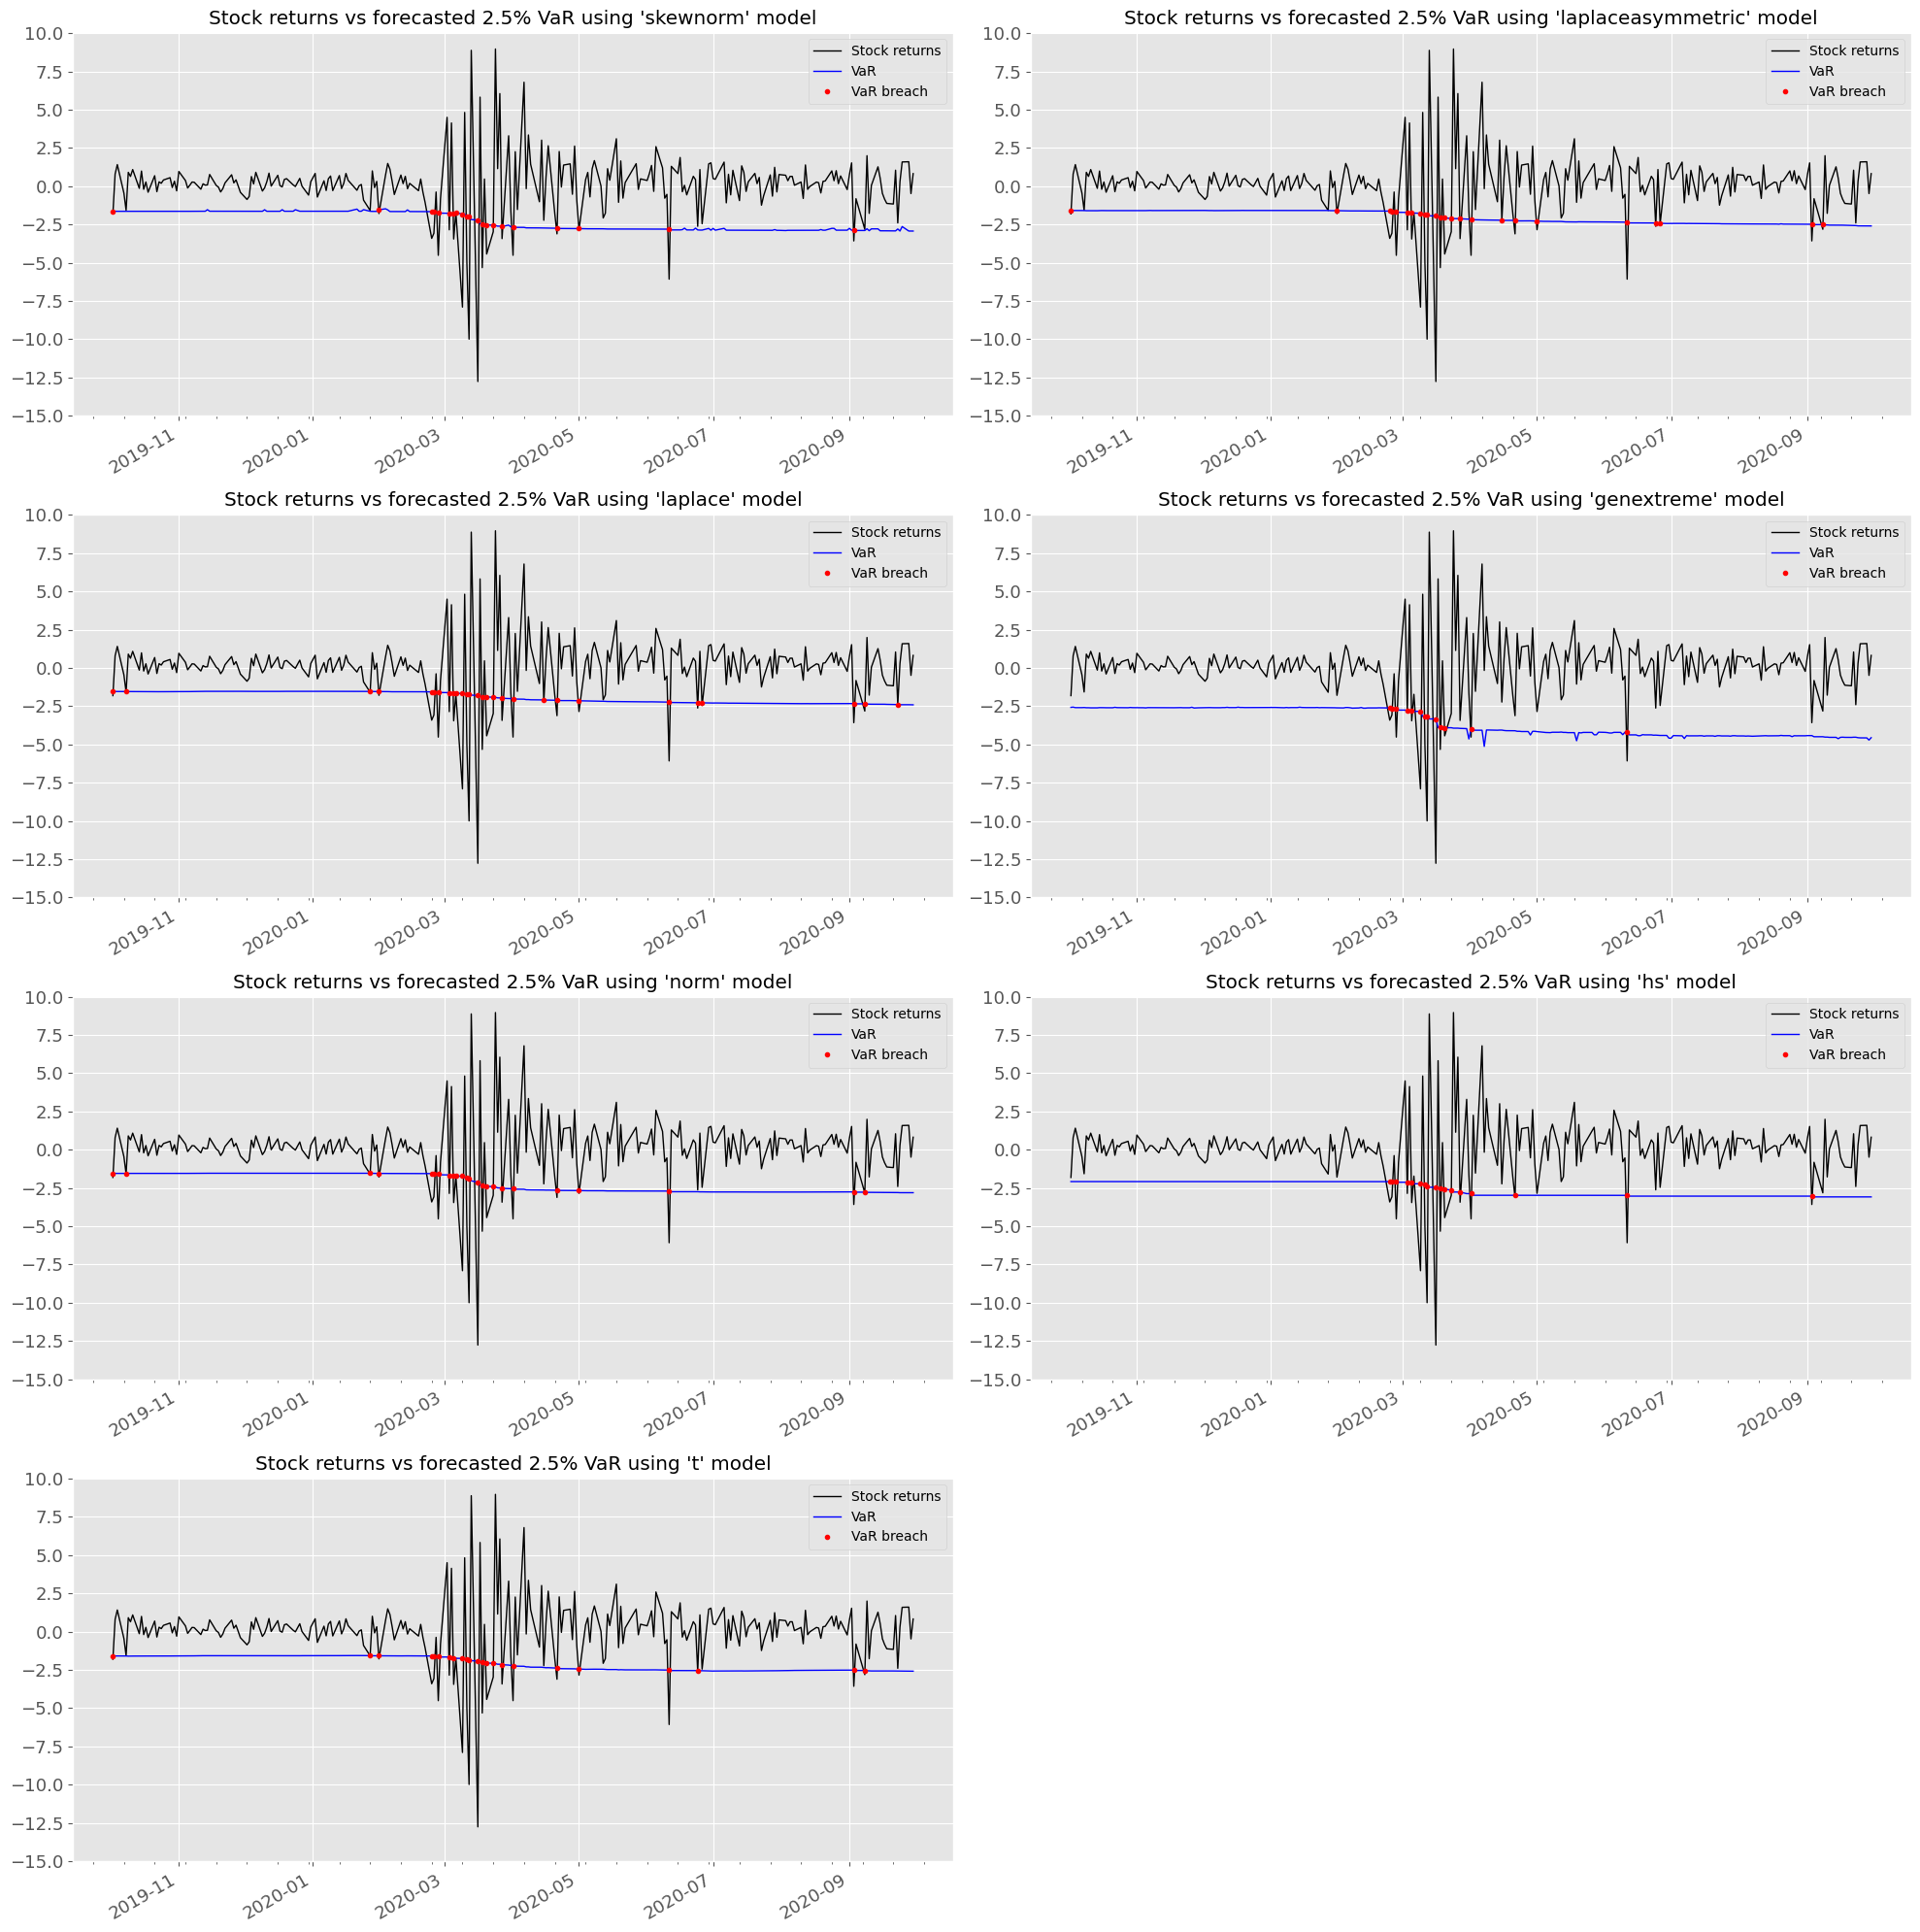

In [12]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))
for i, ax in zip(range(0,7), axes.flat):
    name = models_list[i] + "_25"
    viz25_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz25_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz25_df[name][viz25_df["rr"] < viz25_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 2.5% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-15,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
fig.delaxes(axes[3][1])
plt.show()

## The absolute number and the percentage of exceedances of the VaR level 

In [13]:
output_ex = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        ex = sum(results[name] > results["rr"])
        j = "2.5" if j == "25" else "1"
        output_ex.append([i,j,ex])

output_ex = pd.DataFrame(output_ex, columns = ["model","pval","exceed"])
output_cross_tab_ex_absolute = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'])
output_cross_tab_ex_percent = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'], margins=False, aggfunc='sum')/252*100

In [14]:
display(output_cross_tab_ex_absolute)
display(output_cross_tab_ex_percent)

exceed    
pval                   1 2.5
model                       
genextreme             9  13
hs                    12  17
laplace               18  28
laplaceasymmetric     17  24
norm                  16  24
skewnorm              15  21
t                     13  23

exceed           
pval                      1        2.5
model                                 
genextreme         3.571429   5.158730
hs                 4.761905   6.746032
laplace            7.142857  11.111111
laplaceasymmetric  6.746032   9.523810
norm               6.349206   9.523810
skewnorm           5.952381   8.333333
t                  5.158730   9.126984

##  Kupiec test (unconditional coverage), Christoffersen test (conditional coverage) and Engle test (dynamic quantile)

In [15]:
output_test = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        realisation_array = results["rr"].values
        vars_array = results[name].values
        j = "2.5" if j == "25" else "1"
        p = 0.025 if j == "25" else 0.01
        test1 = kupiec_pof(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test2 = haas_dweibull(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test3 = christoffersen_ccov(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test4 = engle_dq (y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p, k = 3)["p-value"]
        output_test.append([i,j,test1, test2, test3, test4])

output_test = pd.DataFrame(output_test, columns = ["model","pval","kupiec_pof","haas_dweibull","christoffersen_ccov","engle_dq"])
output_cross_tab_test = pd.pivot_table(output_test, index = ['model'], columns=['pval'], values=['kupiec_pof','haas_dweibull','christoffersen_ccov','engle_dq']).round(3)

In [16]:
output_cross_tab_test

christoffersen_ccov      engle_dq      haas_dweibull         \
pval                                1  2.5        1  2.5             1    2.5   
model                                                                           
genextreme                        0.0  0.0      0.0  0.0         0.655  0.222   
hs                                0.0  0.0      0.0  0.0         0.268  0.045   
laplace                           0.0  0.0      0.0  0.0         0.018  0.000   
laplaceasymmetric                 0.0  0.0      0.0  0.0         0.045  0.000   
norm                              0.0  0.0      0.0  0.0         0.119  0.000   
skewnorm                          0.0  0.0      0.0  0.0         0.114  0.001   
t                                 0.0  0.0      0.0  0.0         0.222  0.000   

                  kupiec_pof       
pval                       1  2.5  
model                              
genextreme             0.001  0.0  
hs                     0.000  0.0  
laplace                0.000  0.0  
laplaceasymmetric      0.000  0.0  
norm                   0.000  0.0  
skewnorm               0.000  0.0  
t                      0.000  0.0

## Financial provisions

In [17]:
amount = 1e4 #USD
output_prov = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        prov = sum(abs(results[name].values) * amount)
        j = "2.5" if j == "25" else "1"
        output_prov.append([i,j,prov])

output_prov = pd.DataFrame(output_prov, columns = ["model","pval","prov"])
output_cross_prov = pd.pivot_table(output_prov, index = ['model'], columns=['pval'], values=['prov'])

In [18]:
output_cross_prov

prov              
pval                          1           2.5
model                                        
genextreme         1.079905e+07  8.977319e+06
hs                 9.129988e+06  6.515477e+06
laplace            6.388629e+06  4.846139e+06
laplaceasymmetric  6.744553e+06  5.122759e+06
norm               6.564211e+06  5.515799e+06
skewnorm           6.949245e+06  5.759966e+06
t                  8.895716e+06  5.246073e+06